# Enrichment analysys
### Over representation analysis
* Simplified ilustrative example
* Followed by real case
### GSEA
* Practical using python package

# Supervised machine learning
### Linear regression
### Logistic regression
### SVM
### Overfitting and Bias vs Variance -> Cross validation
### Dimentionality of the input -> PCA

# Unsupervised machine learning
### K-means clustering
* Using TCGA data, HR+/-

# Pathway analysis

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import gseapy as gp
from gseapy.plot import gseaplot
import qvalue

from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, FloatSlider, Dropdown, Text

interact_enrich=interact_manual.options(manual_name="Enrichment analysis")
interact_plot=interact_manual.options(manual_name="Plot")
interact_calc=interact_manual.options(manual_name="Calculate tests")

In [5]:
clinical_data = pd.read_csv('data/brca_clin.tsv.gz', sep ='\t', index_col=2)
clinical_data = clinical_data.iloc[4:,1:]
expression_data = pd.read_csv('data/brca.tsv.gz', sep ='\t', index_col=1)
expression_data = expression_data.iloc[:,2:].T

In [6]:
def differential_test(clinical_df, expression_df, separator, cond1, cond2):
    p_vals = pd.DataFrame(columns = ['p'])
    try:
        group1 = clinical_df[separator] == cond1
        index1 = clinical_df[group1].index
        group2 = clinical_df[separator] == cond2
        index2 = clinical_df[group2].index
    except:
        print('Clinical condition wrong')
    for gene in expression_df.columns:
        try:
            expression = expression_df[gene]
        except:
            print('Gene not found in data')
        expression1 = expression[index1].dropna()
        expression2 = expression[index2].dropna()
        p_val = sp.stats.ttest_ind(expression1, expression2).pvalue
        if p_val == p_val:
            p_vals.loc[gene,'p'] = p_val
    return p_vals

def plot_hist(stats, bins):
    stats = np.array(stats)
    plt.hist(stats, bins = bins)
    plt.show()


def interact_multiple_gene_ttest(Criteria, Group_1, Group_2):
    global BRCA_tests
    BRCA_tests = differential_test(clinical_data, expression_data, Criteria, Group_1, Group_2)
    BRCA_tests = qvalue.qvalues(BRCA_tests)
    plot_hist(BRCA_tests['p'].values, 20)
    with pd.option_context('display.max_rows', None):
        display(BRCA_tests)
        
def ORA(tests, threshold, pathway_db=['KEGG_2019_Human'], stat = 'p'):
    background=set(tests.index)
    gene_list = list(tests.loc[tests[stat]<threshold,stat].index)

    output_enrichr=pd.DataFrame()
    enr=gp.enrichr(
                    gene_list=gene_list,
                    gene_sets=pathway_db,
                    background=background,
                    outdir = None
                )
    results = enr.results[["P-value","Overlap","Term"]].rename(columns={"P-value": "p"})
    return qvalue.qvalues(results)

pathway_db_choice = gp.get_library_name()

        
def interact_ORA(Threshold, Pathway_DB, Statistic):
    threshold = float(threshold)
    results = ORA(BRCA_tests, Threshold, Pathway_DataBase, stat = Statistic)
    with pd.option_context('display.max_rows', None):
        display(results)

In [7]:
interact_calc(interact_multiple_gene_ttest, Criteria=Text('Surgical procedure first'), Group_1 = Text('Simple Mastectomy'), Group_2=Text('Lumpectomy'))
interact_enrich(interact_ORA, Threshold = '5e-2' , Pathway_DB = pathway_db_choice, Statistic=['p','q'])

interactive(children=(Text(value='Surgical procedure first', description='Criteria'), Text(value='Simple Maste…

interactive(children=(Text(value='5e-2', description='Threshold'), Dropdown(description='Pathway_DB', options=…

<function __main__.interact_ORA(Threshold, Pathway_DB, Statistic)>

In [7]:
def gsea(tests, pathway_db = 'KEGG_2019_Human' ):
    pre_res = gp.prerank(rnk=tests['p'], 
                    gene_sets=pathway_db,
                    processes=4,
                    permutation_num=100, # reduce number to speed up testing
                    outdir=None, format='png')
    return pre_res

def interact_gsea(Pathway_DB):
    global Results_gsea
    Results_gsea = gsea(BRCA_tests, pathway_db=Pathway_DB)
    with pd.option_context('display.max_rows', None):
        display(Results_gsea.res2d[['pval', 'fdr']])

In [ ]:
interact_calc(interact_multiple_gene_ttest, Criteria=Text('Surgical procedure first'), Group_1 = Text('Simple Mastectomy'), Group_2=Text('Lumpectomy'))
interact_enrich(interact_gsea, Pathway_DB = pathway_db_choice)

# Machine learning, SVMs

In [76]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [94]:
def split_data(clinical_df, expression_df, separator, cond1, cond2):
    try:
        group1 = clinical_df[separator] == cond1
        index1 = clinical_df[group1].index
        group2 = clinical_df[separator] == cond2
        index2 = clinical_df[group2].index
    except:
        print('Clinical condition wrong')
    expression1 = expression_df.loc[index1].dropna()
    expression2 = expression_df.loc[index2].dropna()
    expression = pd.concat([expression1, expression2])
    X = expression.values
    y = np.append(np.repeat(0, len(expression1)), np.repeat(1, len(expression2)))
    return X, y

def train_SVM(X, y, C=1, scale = False):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    clf = LinearSVC(C=C, max_iter=10000)
    clf.fit(X,y)
    return clf

def print_accuracy(X_train, y_train, X_test, y_test, clf):
    y_train_pred = clf.predict(X_train)
    ac_matrix_train = confusion_matrix(y_train, y_train_pred)
    y_test_pred = clf.predict(X_test)
    ac_matrix_test = confusion_matrix(y_test, y_test_pred)
    display(pd.DataFrame(np.concatenate((ac_matrix_train,ac_matrix_test), axis =1), columns = ["predicted G1 (training)","predicted G2 (training)", "predicted G1 (test)","predicted G2 (test)"],index=["actual G1","actual G2"]))
    
def plot_pca_variance(X):
    pca = PCA()
    pca.fit(X)
    plt.rcParams["figure.figsize"] = (20,10)
    sns.set(style='darkgrid', context='talk')
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance');

In [39]:
X, y = split_data(clinical_data, expression_data, 'Surgical procedure first', 'Simple Mastectomy', 'Lumpectomy')

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = train_SVM(X_train, y_train)


In [73]:

print_accuracy(X_train, y_train, X_test, y_test, clf)

,predicted G1 (training),predicted G2 (training),predicted G1 (test),predicted G2 (test)
actual G1,112,0,6,10
actual G2,0,176,3,14


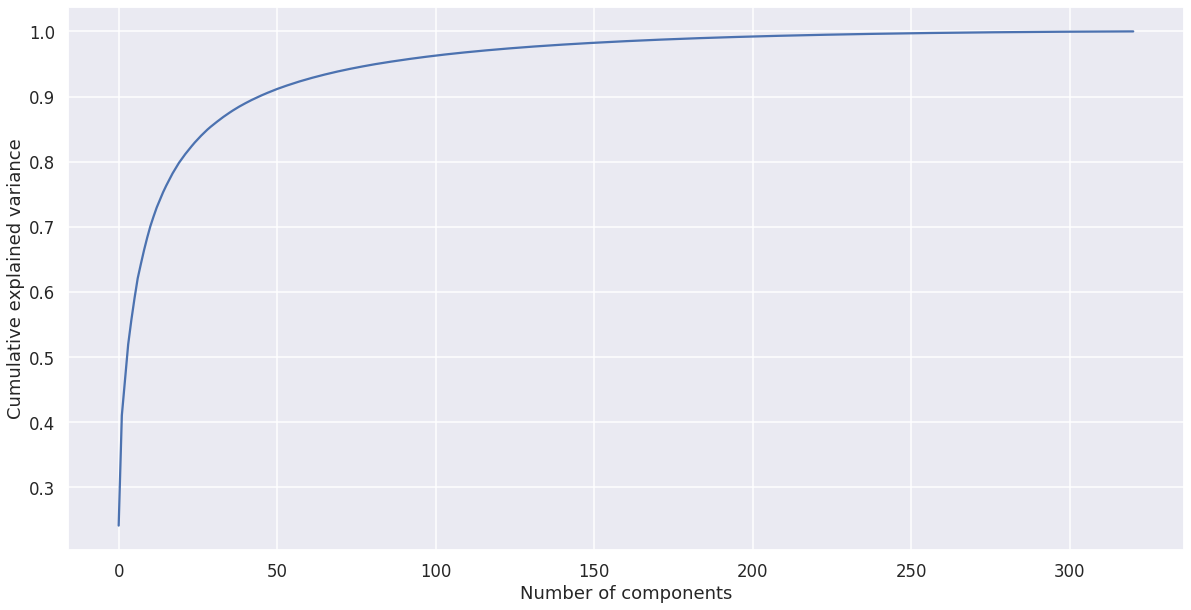

In [95]:
plot_pca_variance(X)

# References

Weinstein, John N., et al. 'The cancer genome atlas pan-cancer analysis project.' Nature genetics 45.10 (2013): 1113-1120.

Patrício, Miguel, et al. “Using Resistin, Glucose, Age and BMI to Predict the Presence of Breast Cancer.” BMC Cancer, vol. 18, no. 1, Jan. 2018, p. 29. BioMed Central, doi:10.1186/s12885-017-3877-1.